# Simulation of a prism applied to a Non-linear inverse problem using Nelder-Mead Algorithm (Simplex)

## Importing libraries

In [1]:
%matplotlib inline
from fatiando.gridder import regular, spacing
from fatiando.mesher import Prism
from fatiando.utils import ang2vec
from fatiando.gravmag import prism
from fatiando.constants import CM, T2NT
import numpy as np
import matplotlib.pyplot as plt
from visual import histeq

## Prism parameters

### Dimension of the prism

In [2]:
dimx = 5.  # in mm
dimy = 5.
dimz = 5.

In [3]:
Lx = 1e-3*dimx

In [4]:
Ly = 1e-3*dimy

In [5]:
Lz = 1e-3*dimz

### Sensor-to-sample distance

In [6]:
voo = 500.
dist = voo*1e-6
sts = dist + (0.5*Lz) 

## Parameters for the observation coordinate

In [7]:
Nx = 50
Ny = 50
shape = (Nx,Ny)

In [8]:
xmax = 1e-3*6.
xmin = -xmax
ymax = 1e-3*6.
ymin = -ymax

area = [xmin,xmax,ymin,ymax]

In [9]:
x,y,z = regular(area,shape, -sts)

## Generating the sample

In [10]:
intensity = 0.1
inclination = 90.
declination = 0.

In [11]:
mag = ang2vec(intensity,inclination,declination)

In [12]:
sample = [Prism(-0.5*Lx,0.5*Lx,-0.5*Ly,0.5*Ly,-0.5*Lz,0.5*Lz, props={'magnetization': mag})]

## True parameters

In [13]:
p_true = np.array([voo,intensity]) ## (sensor-to-sample,intensity)

## Calculating the observed data

In [14]:
Bz = prism.bz(x,y,z,sample)

In [15]:
np.random.seed(seed=40)

std_noise = 0.02*np.max(np.abs(Bz))

r = np.random.normal(0.0, std_noise, Nx*Ny)

print '%.3f nT' % std_noise

0.896 nT


In [16]:
Bz_obs = Bz + r

## Calculating the predicted data

In [17]:
def pred_data(x,y,p,sample,inc,dec):
    '''
    Calculate the predicted data.
    '''
    voo = p[0]
    dist = voo*1e-6
    sts = dist + (0.5*Lz) 
    z = -sts*np.ones_like(x)
    
    m = p[1]
    jx = np.cos(np.deg2rad(inc))*np.cos(np.deg2rad(dec))
    jy = np.cos(np.deg2rad(inc))*np.sin(np.deg2rad(dec))
    jz = np.sin(np.deg2rad(inc))
    bz = prism.kernelxz(x,y,z,sample[0])*jx+\
         prism.kernelyz(x,y,z,sample[0])*jy+\
         prism.kernelzz(x,y,z,sample[0])*jz
    bz *= CM*T2NT*m
    return  bz

## Observed data and predicted data

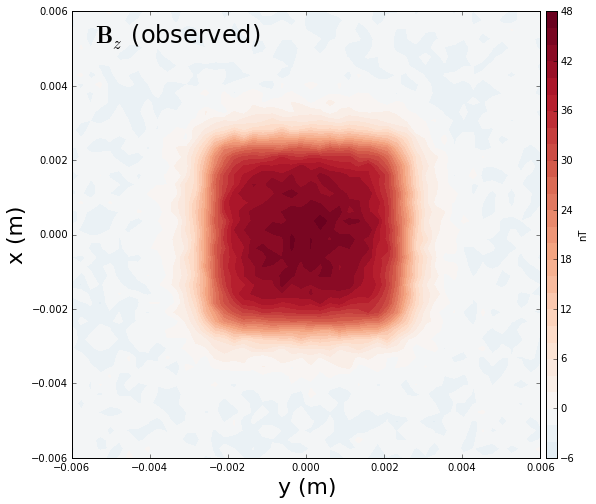

In [18]:
title_font = 22
bottom_font = 16
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(10,8))

ranges = saturation_factor*np.abs([Bz_obs.max(), Bz_obs.min()]).max()

plt.contourf(y.reshape(shape), x.reshape(shape), Bz_obs.reshape(shape),30, cmap=plt.cm.RdBu_r, vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT')
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.annotate('$\mathbf{B}_z$ (observed)', xy = (0.05, 0.93), 
             xycoords = 'axes fraction', fontsize=24)

plt.show()

## Visualization of the data misfit

In [19]:
Nm = 20
m_range = np.linspace(0.01,.2,num=Nm)

In [20]:
Nh = 20
h_range = np.linspace(10.,1000.,num=Nh)

In [21]:
h_range,m_range = np.meshgrid(h_range,m_range)

In [22]:
shape_phi = (Nh,Nm)

In [23]:
misfit = []
for mi,hi in zip (m_range.ravel(),h_range.ravel()):
    p = np.array([hi,mi])
    Bz_pred_it = pred_data(x,y,p,sample,inclination,declination)
    res = Bz_obs - Bz_pred_it 
    misfit.append(np.linalg.norm(res))

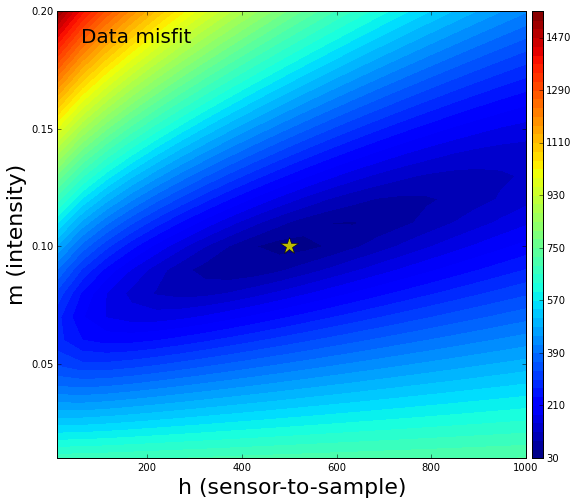

In [24]:
title_font = 22
bottom_font = 16
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(10,8))
plt.contourf(h_range, m_range, np.array(misfit).reshape(shape_phi), 50)
plt.plot(voo,intensity,'y*',markersize=18)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0)
plt.xlabel('h (sensor-to-sample)', fontsize = title_font)
plt.ylabel('m (intensity)', fontsize = title_font)
plt.annotate('Data misfit', xy = (0.05, 0.93), xycoords = 'axes fraction', fontsize=20)

plt.show()

## Calculating the simplex method for the prism

### Parameters for the algorithm

In [25]:
itmax = 50

# initial approximation 

p0 = np.array([100.,.18,100.,.15,200.,.16]).reshape(3,2)

B01 = pred_data(x,y,p0[0],sample,inclination,declination)
r01 = Bz_obs - B01
phi01 = np.linalg.norm(r01)

B02 = pred_data(x,y,p0[1],sample,inclination,declination)
r02 = Bz_obs - B02
phi02 = np.linalg.norm(r02)

B03 = pred_data(x,y,p0[2],sample,inclination,declination)
r03 = Bz_obs - B03
phi03 = np.linalg.norm(r03)

phi0 = np.array([phi01, phi02, phi03])

i_L = np.argmin(phi0)
px = [p0[i_L][0]]
py = [p0[i_L][1]]

# List of phi
phi_it = [phi0[i_L]]

# Algorithm parameters

alpha = 1. # reflexion parameter
gamma = 1.2 # expansion parameter
beta = 0.2 # contraction parameter

### Nelder-Mead Algorithm

In [26]:
for i in range(itmax):
    # step 3 : maximum and minimun value
    
    B01 = pred_data(x,y,p0[0],sample,inclination,declination)
    r01 = Bz_obs - B01
    phi01 = np.linalg.norm(r01)

    B02 = pred_data(x,y,p0[1],sample,inclination,declination)
    r02 = Bz_obs - B02
    phi02 = np.linalg.norm(r02)

    B03 = pred_data(x,y,p0[2],sample,inclination,declination)
    r03 = Bz_obs - B03
    phi03 = np.linalg.norm(r03)

    phi0 = np.array([phi01, phi02, phi03])
    
    i_L = np.argmin(phi0)
    i_H = np.argmax(phi0)
    
    p_L = p0[i_L]
    B_L = pred_data(x,y,p_L,sample,inclination,declination)
    r_L = Bz_obs - B_L
    phi_L = np.linalg.norm(r_L)
    
    p_H = p0[i_H]
    B_H = pred_data(x,y,p_H,sample,inclination,declination)
    r_H = Bz_obs - B_H
    phi_H = np.linalg.norm(r_H)
    
    p_i = np.delete(p0,[i_H,i_L],0).reshape(2,)
    B_i = pred_data(x,y,p_i,sample,inclination,declination)
    r_i = Bz_obs - B_i
    phi_i = np.linalg.norm(r_i)
    
    p_del = np.delete(p0,i_H,0)
    phi_del = np.delete(phi0,i_H,0)
    
    # step 4 : centroid calculation
    p_c = 0.5*(p_L + p_i)
        
    # step 5 : reflection
    delta = (p_c - p_H)
    p_R = p_c + alpha*delta
        
    # step 6 : Calculation of the phi for Reflection
    B_R = pred_data(x,y,p_R,sample,inclination,declination)
    r_R = Bz_obs - B_R
    phi_R = np.linalg.norm(r_R)
        
    ## step 6a :
    if phi_R < phi_L:
        p_E = p_c + gamma*(p_R - p_c)
        B_E = pred_data(x,y,p_E,sample,inclination,declination)
        r_E = Bz_obs - B_E
        phi_E = np.linalg.norm(r_E)
        ### case 1
        if phi_E <= phi_L:
            p_H = p_E
            p = np.vstack((p_del,p_E))
            phi = np.hstack((phi_del,phi_E))
        ### case 2
        elif phi_E > phi_L:
            p = np.vstack((p_del,p_R))
            phi = np.hstack((phi_del,phi_R))
    
    ## step 6b :
    if phi_R >= phi_L and phi_R < phi_i:
        p = np.vstack((p_del,p_R))
        phi = np.hstack((phi_del,phi_R))
    
    ## step 6c:
    if phi_R > phi_del[0] and phi_R > phi_del[1] :
        ### case 1
        if phi_R < phi_H:
            p_contrac = p_c + beta*(p_R - p_c)
            B_contrac = pred_data(x,y,p_contrac,sample,inclination,declination)
            r_contrac = Bz_obs - B_contrac
            phi_contrac = np.linalg.norm(r_contrac)
            #### case 1a
            if phi_contrac < phi_R:
                p = np.vstack((p_del,p_contrac))
                phi = np.hstack((phi_del,phi_contrac))
            #### casa 1b
            elif phi_contrac >= phi_R:
                p_H = 0.5*(p_H + p_L)
                p_i = 0.5*(p_i + p_L)
                
                B_H = pred_data(x,y,p_H,sample,inclination,declination)
                r_H = Bz_obs - B_H
                phi_H = np.linalg.norm(r_H)
                
                B_i = pred_data(x,y,p_i,sample,inclination,declination)
                r_i = Bz_obs - B_i
                phi_i = np.linalg.norm(r_i)
                
                p = np.vstack((p_L, p_H,p_i))
                phi = np.hstack((phi_L, phi_H,phi_i))
        
        ### case 2
        if phi_R >= phi_H:
            p_cont = p_c + beta*(p_H - p_c)
            B_cont = pred_data(x,y,p_cont,sample,inclination,declination)
            r_cont = Bz_obs - B_cont
            phi_cont = np.linalg.norm(r_cont)
            #### case 2a
            if phi_contrac < phi_H:
                p = np.vstack((p_del,p_contrac))
                phi = np.hstack((phi_del,phi_contrac))
            #### case 2b
            elif phi_contrac >= phi_H:
                p_H = 0.5*(p_H + p_L)
                p_i = 0.5*(p_i + p_L)
                
                B_H = pred_data(x,y,p_H,sample,inclination,declination)
                r_H = Bz_obs - B_H
                phi_H = np.linalg.norm(r_H)
                
                B_i = pred_data(x,y,p_i,sample,inclination,declination)
                r_i = Bz_obs - B_i
                phi_i = np.linalg.norm(r_i)
                
                p = np.vstack((p_L, p_H,p_i))
                phi = np.hstack((phi_L, phi_H,phi_i))
    
    
    px.append(p0[i_L][0])
    py.append(p0[i_L][1])
    phi_it.append(phi_L)
    
    if abs(np.sum(phi - phi0)/phi0.size) <= 1e-8:
        break
    else:
        p0 = p
        phi0 = phi

In [27]:
print p0[i_L]

[  5.06315709e+02   1.00681775e-01]


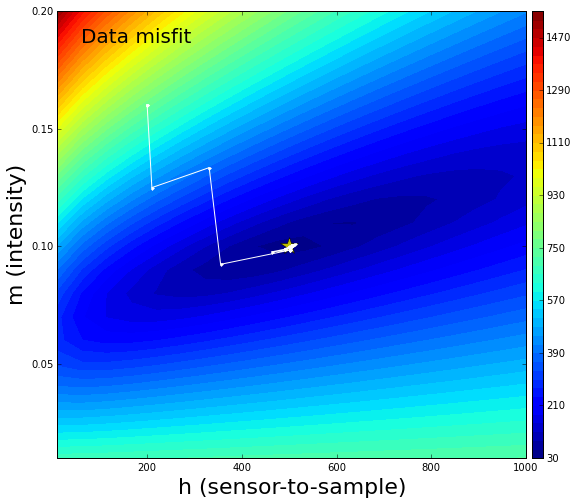

In [28]:
title_font = 22
bottom_font = 16
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(10,8))
plt.contourf(h_range, m_range, np.array(misfit).reshape(shape_phi), 50)
plt.plot(voo,intensity,'y*',markersize=18)
plt.plot(px,py,'w.-')
plt.colorbar(pad=0.01, aspect=40, shrink=1.0)
plt.xlabel('h (sensor-to-sample)', fontsize = title_font)
plt.ylabel('m (intensity)', fontsize = title_font)
plt.annotate('Data misfit', xy = (0.05, 0.93), xycoords = 'axes fraction', fontsize=20)

plt.show()

## Plotting misfit

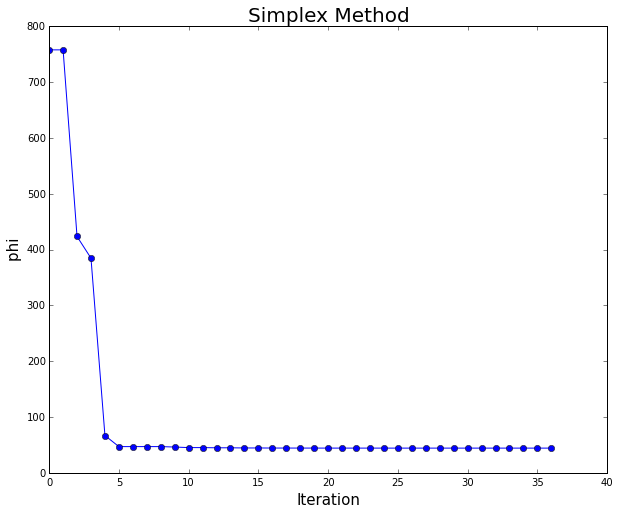

In [29]:
plt.figure(figsize=(10,8))

plt.plot(phi_it, 'o-')
plt.title('Simplex Method',fontsize=20)
plt.ylabel('phi ',fontsize=15)
plt.xlabel('Iteration',fontsize=15)

plt.show()


## Data Fitting 

In [30]:
Bz_calc = pred_data(x,y,p0[i_L],sample,inclination,declination)

In [31]:
res = Bz_obs - Bz_calc

In [32]:
r_mean = np.mean(res)
r_std = np.std(res)
r_norm = (res - r_mean)/r_std

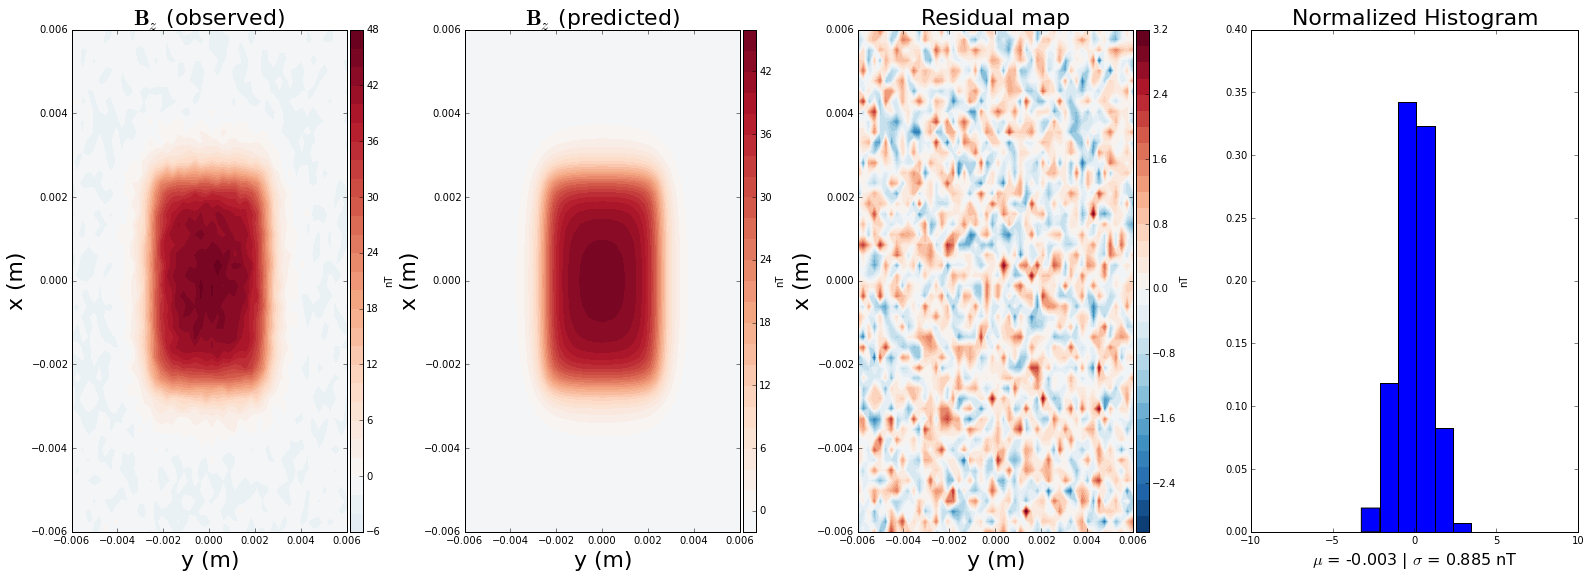

In [33]:
title_font = 22
bottom_font = 16
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(27,9))

ranges = saturation_factor*np.abs([Bz_obs.max(), Bz_obs.min()]).max()

plt.subplot(1,4,1)

plt.contourf(y.reshape(shape), x.reshape(shape), Bz_obs.reshape(shape),30, cmap=plt.cm.RdBu_r, vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT')
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('$\mathbf{B}_z$ (observed)',fontsize=title_font)

plt.subplot(1,4,2)

plt.contourf(y.reshape(shape), x.reshape(shape), Bz_calc.reshape(shape), 30, cmap=plt.cm.RdBu_r, vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT')
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('$\mathbf{B}_z$ (predicted)', fontsize=title_font)

plt.subplot(1,4,3)
ranges = saturation_factor*np.abs([res.max(), res.min()]).max()

plt.contourf(y.reshape(shape), x.reshape(shape), res.reshape(shape), 30, cmap=plt.cm.RdBu_r, vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT')
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('Residual map', fontsize=title_font)

plt.subplot(1,4,4)
plt.title('Normalized Histogram', fontsize=title_font)
plt.xlabel('$\mu$ = %.3f | $\sigma$ = %.3f nT' % (r_mean, r_std), fontsize = bottom_font)
nbins = int((np.max(r_norm) - np.min(r_norm)))
plt.hist(r_norm,bins=nbins,normed=True)
plt.ylim(0.,0.4)
plt.xlim(-10., 10.)



plt.show()